In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
df = pd.read_csv("../data/external/toxic.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
# checking dimensions of dataset
df.shape

(159571, 8)

In [14]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [15]:
from wordcloud import WordCloud, STOPWORDS

def plot_word_cloud(comments, title):
    plt.figure(figsize=(15,15))
    text = comments.comment_text.values
    comments_cloud = WordCloud(
                            font_path='arial',
                            stopwords=STOPWORDS,
                            background_color='black',
                            collocations=False,
                            width=2500,
                            height=1800).generate(" ".join(text))
    plt.axis('off')
    plt.title(f"Most words used in {title} comments")
    plt.imshow(comments_cloud)

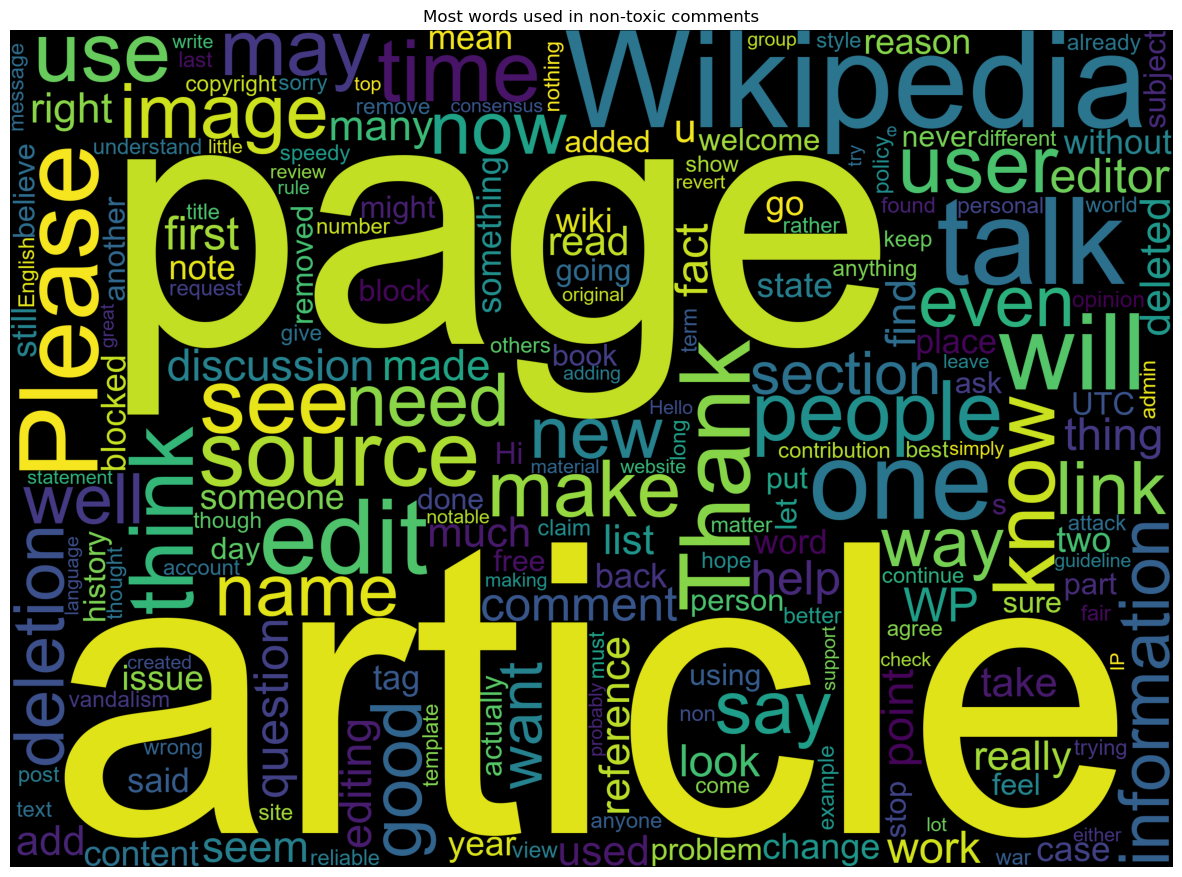

In [16]:
# visualizing most words used in non-toxic and inapporpriate comments
non_toxic = df.query('toxic==0 & severe_toxic==0 & obscene==0 & threat==0 & insult==0 & identity_hate==0')
plot_word_cloud(non_toxic, "non-toxic")

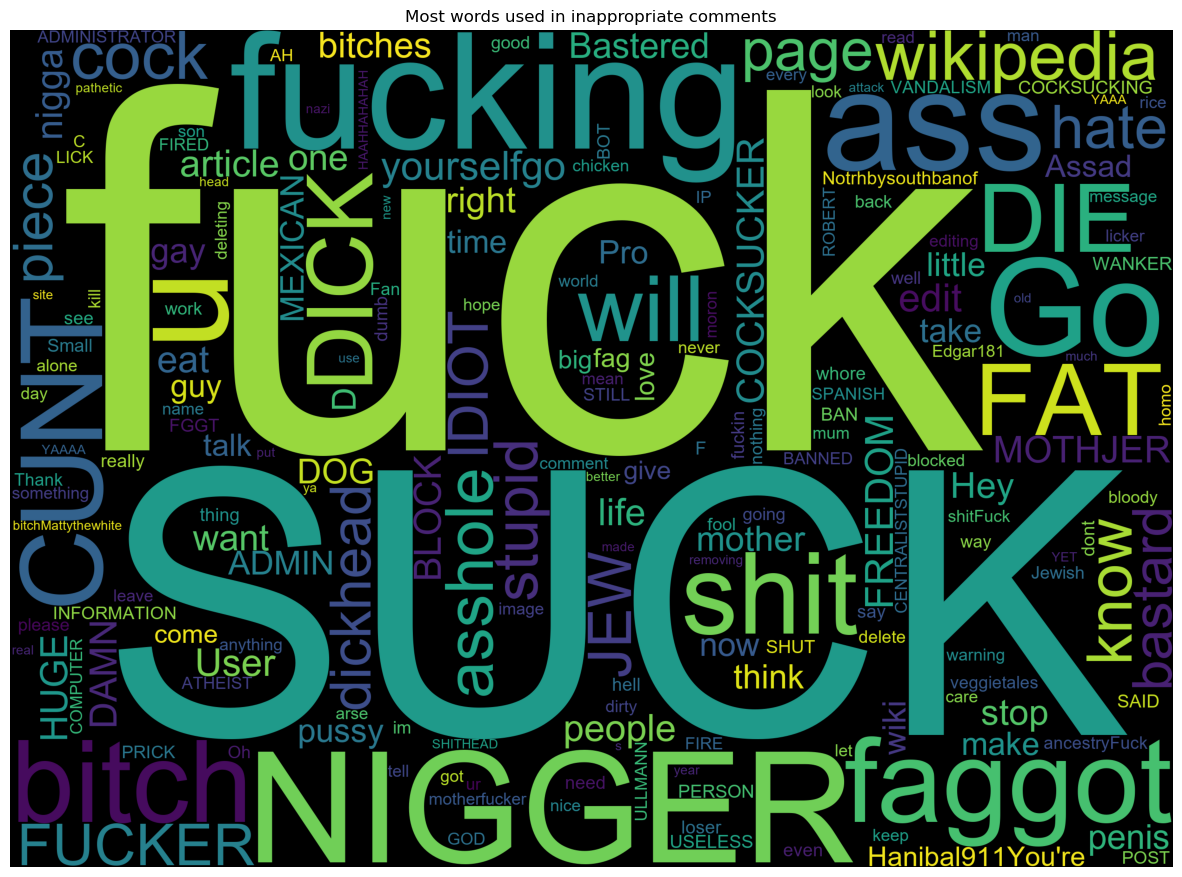

In [17]:
# visualizing most words used in inappropriate comments
inappropriate = df.query('toxic!=0 & obscene!=0 & insult!=0') # allowing other labels to be anything since they are less
plot_word_cloud(inappropriate, "inappropriate")

<BarContainer object of 6 artists>

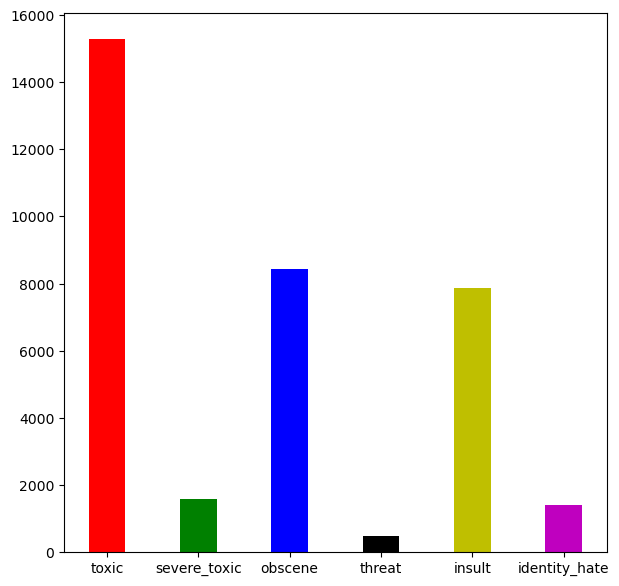

In [18]:
# checking label distribution
fig, ax = plt.subplots(figsize=(7,7))
class_counts = [df.toxic.value_counts()[1], df.severe_toxic.value_counts()[1], df.obscene.value_counts()[1], df.threat.value_counts()[1], df.insult.value_counts()[1], df.identity_hate.value_counts()[1]]
ax.bar(df.columns[2:], class_counts, color = ['r','g','b','k','y','m','c'], width = 0.4)

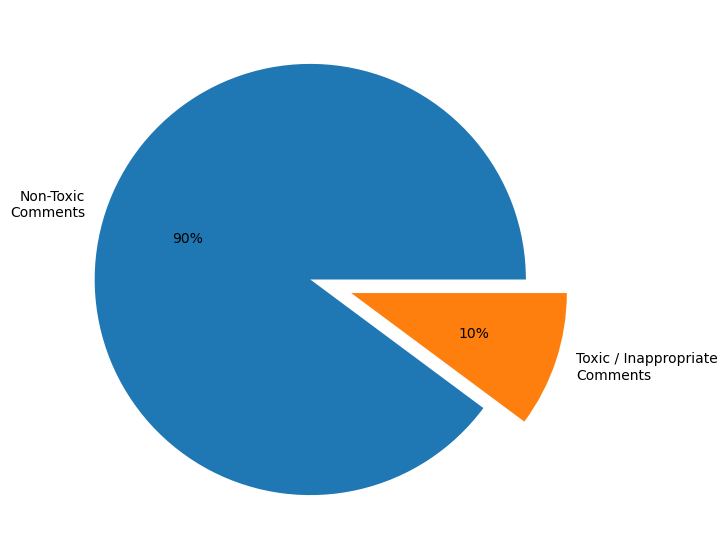

In [19]:
# non toxic comments out of total dataset
labels = ['Non-Toxic\nComments', 'Toxic / Inappropriate\nComments']
fig = plt.figure(figsize = (7, 7))
explode = [0.0, 0.2]
plt.pie([non_toxic.shape[0], df.shape[0] - non_toxic.shape[0]], autopct='%1.0f%%', labels=labels, explode=explode)
plt.show()

<BarContainer object of 6 artists>

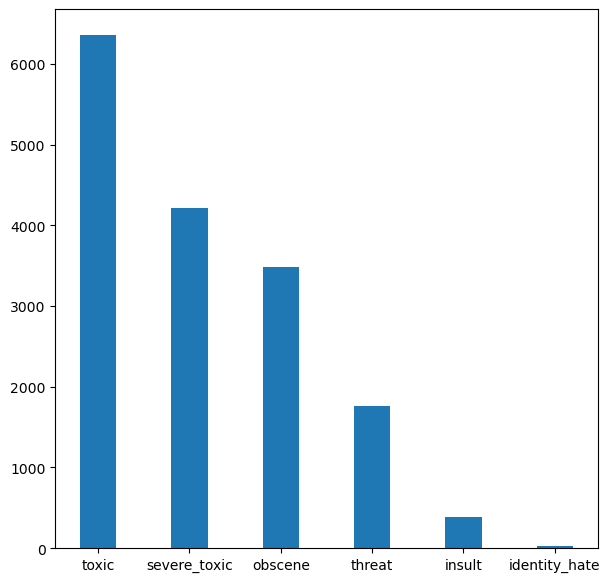

In [20]:
# checking how many labels co-
fig, ax = plt.subplots(figsize=(7,7))
rowSums = df.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
ax.bar(df.columns[2:], multiLabel_counts.values, width = 0.4)

Above plots shows that 90% of comments are completely non-toxic and there is imbalance in label count. Also there are labels that occur with each other. Hence, we need to divide our training and validation sets using stratification.

In [21]:
# dropping id column
df.drop(labels=['id'], axis=1, inplace=True)

In [25]:
# checking ratio of each label in dataset
def check_ratio(df):
    for label in df.columns:
        ratio = df[label].value_counts()[1] / df[label].value_counts()[0]
        print(f'{label} ratio: {round(ratio, 4)}')

check_ratio(df.iloc[:, 1:])

toxic ratio: 0.106
severe_toxic ratio: 0.0101
obscene ratio: 0.0559
threat ratio: 0.003
insult ratio: 0.0519
identity_hate ratio: 0.0089


In [23]:
# splitting dependent and independent variables
X = df.iloc[:, 0]
y = df.iloc[:, 1:]

In [26]:
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_val, y_train, y_val = iterative_train_test_split(X, y, 0.8)

In [28]:
print("Training instances = ", X_train.shape[0])
print("Validation instances = ", X_val.shape[0])

Training instances =  127656
Validation instances =  31915


In [29]:
# checking ratio of each label in training set
check_ratio(y_train)

toxic ratio: 0.106
severe_toxic ratio: 0.0101
obscene ratio: 0.0559
threat ratio: 0.0029
insult ratio: 0.0519
identity_hate ratio: 0.0089


Ratio of each label in training and validation set is now maintained equal

In [30]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

In [31]:
train = X_train.assign(toxic=y_train.toxic, severe_toxic=y_train.severe_toxic, obscene=y_train.obscene, threat=y_train.threat, insult=y_train.insult, identity_hate=y_train.identity_hate)
val = X_val.assign(toxic=y_val.toxic, severe_toxic=y_val.severe_toxic, obscene=y_val.obscene, threat=y_val.threat, insult=y_val.insult, identity_hate=y_val.identity_hate)

In [32]:
# checking word count for each comment to determine max len value for input sequence
X_train["WORD_COUNT"] = X_train["comment_text"].apply(lambda x: len(x.split()))

array([[<Axes: title={'center': 'WORD_COUNT'}>]], dtype=object)

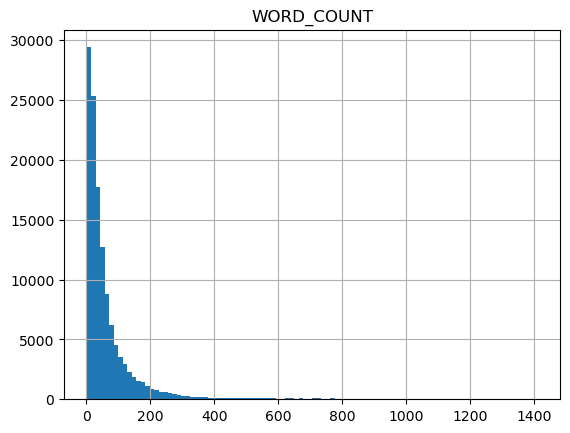

In [33]:
X_train.hist('WORD_COUNT', bins=100)
# from below histogram, we can set max len as 200

In [35]:
# saving the validation and train split for pre-processing
train.to_csv('../data/toxic/train/train.csv', index=False)  
val.to_csv('../data/toxic/val/val.csv', index=False) 